# Use MANA for the entire dataset

## MANA-7: Full Dataset Implementation

**Objective:** Apply MANA to the complete dataset with all samples.

**Workflow:**
1. ✅ Load full dataset (with fix for h5ad reading issues)
2. ✅ Run scVI on all samples for unified latent representation
3. ✅ Build spatial neighborhood graphs
4. ✅ Apply MANA with optimal parameters (gaussian kernel, hop_decay=0.2, n_layers=3)
5. ✅ Cluster cells in MANA feature space
6. ✅ Visualize results across all samples
7. ✅ Evaluate clustering quality (spatial & expression coherence)
8. ✅ Optional: Compare with CellCharter on full dataset

**Key Parameters (from MANA-6 benchmark):**
- `distance_kernel='gaussian'` (winner with 0.693 composite score)
- `hop_decay=0.2` (optimal from MANA-4)
- `n_layers=3` (optimal balance from MANA-5)
- `aggregations='mean'` (standard approach)

In [25]:
import scanpy as sc


## read entire dataset

In [26]:
# Fix for anndata reading issues with problematic .uns entries
# The error occurs when some .uns entries can't be deserialized
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


In [27]:

try:
    adata = sc.read_h5ad('/Volumes/processing2/RRmap/data/EAE_proseg_clustered_louvain_leiden_all_sections_annotated_rotated_cellcharter_neigh2_251219.h5ad')
    print(f"Successfully loaded: {adata.shape[0]} cells × {adata.shape[1]} genes")
except Exception as e:
    print(f"Initial read failed: {e}")
    print("Attempting to read with backed mode and then copy...")
    
    # Read in backed mode (doesn't load everything into memory)
    adata_backed = sc.read_h5ad(
        '/Volumes/processing2/RRmap/data/EAE_proseg_clustered_louvain_leiden_all_sections_annotated_rotated_cellcharter_neigh2_251219.h5ad',
        backed='r'
    )
    
    # Copy to memory, which skips problematic .uns entries
    adata = adata_backed.to_memory()
    
    print(f"Successfully loaded: {adata.shape[0]} cells × {adata.shape[1]} genes")

Successfully loaded: 877141 cells × 5101 genes


In [28]:
# Check data structure
print(f"Total cells: {adata.n_obs:,}")
print(f"Total genes: {adata.n_vars:,}")
print(f"\nSamples: {adata.obs['sample_id'].nunique() if 'sample_id' in adata.obs else 'sample_id not found'}")
print(f"\nAvailable .obs columns:\n{list(adata.obs.columns)}")
print(f"\nAvailable .obsm keys:\n{list(adata.obsm.keys())}")
print(f"\nAvailable .uns keys:\n{list(adata.uns.keys())}")

Total cells: 877,141
Total genes: 5,101

Samples: 107

Available .obs columns:
['cell', 'centroid_x', 'centroid_y', 'centroid_z', 'component', 'volume', 'surface_area', 'scale', 'region', 'sample_id', 'proseg_cluster', 'output_folder', 'Num', 'n_genes', 'n_counts', 'louvain_0.5', 'louvain_1', 'louvain_1.5', 'louvain_2', 'louvain_2.5', 'louvain_3', 'louvain_3.5', 'Cluster', 'Level1', 'Level2', 'Level3', 'Level3.1', 'grid_label', 'rbd_domain', 'rbd_domain_0.1', 'rbd_domain_0.2', 'rbd_domain_0.3', 'rbd_domain_0.5', 'rbd_domain_0.6', 'rbd_domain_0.7', 'rbd_domain_0.8', 'rbd_domain_0.9', 'rbd_domain_1.1', 'rbd_domain_1', 'rbd_domain_1.25', 'rbd_domain_1.4', 'rbd_domain_1.5', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_2.5', 'leiden_3', 'leiden_3.5', 'sample_name', 'course', 'condition', 'model', 'cytetype_annotation_louvain_3.5', 'cytetype_cellOntologyTerm_louvain_3.5', 'cluster_id', 'author_label', 'annotation', 'Class', 'state', 'CL_term', 'CL_term_id', 'confidence', 'auth

## Part 1: Run scVI on All Samples

We need to train scVI on the full dataset to get a unified latent representation across all samples.

### Should we subset to highly variable genes (HVGs)?

**Answer: NO** - scVI is designed to use all genes.

**Why use all 5,101 genes?**
- ✅ scVI's neural network learns which genes are informative during training
- ✅ "Non-variable" genes can still contain cell type-specific information
- ✅ Gene selection was designed for PCA (linear methods), not deep learning
- ✅ scVI authors explicitly recommend using all genes
- ✅ With only 5,101 genes, computational cost is minimal

**When to consider HVGs:**
- ⚠️ Only if you have >20,000 genes AND severe memory constraints
- Even then, scVI performance often degrades with gene subsetting

**Our case:** 5,101 genes is already a reasonable number. Using all genes will give the best performance.

In [4]:
# Verify we're using all genes
print(f"Using all {adata.n_vars:,} genes for scVI training")
print(f"Number of cells: {adata.n_obs:,}")
print(f"\nTotal parameters to model: {adata.n_obs * adata.n_vars:,}")

# For reference: if we had used HVG selection
# (we're NOT doing this, just showing for comparison)
print(f"\n--- For comparison only (NOT recommended) ---")
print(f"If we selected top 2,000 HVGs: {adata.n_obs * 2000:,} parameters")
print(f"Information loss: {(1 - 2000/adata.n_vars)*100:.1f}% of genes discarded")
print(f"\nConclusion: Using all {adata.n_vars:,} genes ✓")

Using all 5,101 genes for scVI training
Number of cells: 877,141

Total parameters to model: 4,474,296,241

--- For comparison only (NOT recommended) ---
If we selected top 2,000 HVGs: 1,754,282,000 parameters
Information loss: 60.8% of genes discarded

Conclusion: Using all 5,101 genes ✓


In [5]:
import scvi

# Set up scVI
# Assumes you have a 'sample_id' or similar batch key
batch_key = 'sample_id'  # Adjust this to your actual batch column name

# Setup anndata for scVI
scvi.model.SCVI.setup_anndata(
    adata,
    layer=None,  # Use .X (raw counts)
    batch_key=batch_key,  # Important: correct for batch effects between samples
)

print(f"scVI setup complete. Batch key: {batch_key}")
print(f"Number of batches: {adata.obs[batch_key].nunique()}")

/Users/christoffer/miniconda3/envs/cellcharter-env-new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scVI setup complete. Batch key: sample_id
Number of batches: 107


### Performance Optimization for Large Dataset

For 877K cells on MPS, we need to optimize training speed.

**Why is training slow at 100s/epoch?**

For 877K cells on MPS with batch_size=512:
- ❌ **Too many batches**: 877,141 / 512 = ~1,710 batches per epoch
- ❌ **Frequent CPU→GPU transfers**: Each batch requires data transfer
- ❌ **MPS sparse→dense overhead**: Converting sparse matrices on MPS is slow

**Solutions:**
1. ✅ **Increase batch_size to 2048-4096**: Reduces batches to ~400-200 per epoch
2. ✅ **Keep dl_num_workers=0**: MPS doesn't benefit from multiprocessing
3. ⚠️ **Consider CPU fallback**: For very sparse data, CPU can actually be faster than MPS
4. ✅ **Reduce max_epochs with early stopping**: Less total training time

**Expected improvement:** 
- With batch_size=2048: ~25-40s/epoch (2.5-4× faster)
- With batch_size=4096: ~15-25s/epoch (4-6× faster)

In [6]:
# Optimization 1: Increase batch size significantly
# For 877K cells, batch_size=512 is too small (causes frequent CPU→GPU transfers)
# MPS can handle much larger batches
scvi.settings.batch_size = 2048  # or even 4096 if memory allows

# Optimization 2: Set num_workers to 0 for MPS (you already have this)
scvi.settings.dl_num_workers = 0  # MPS doesn't benefit from multiprocessing

# Optimization 3: Check if data is in memory (not backed mode)
print(f"Data backed: {adata.isbacked}")
print(f"Data shape: {adata.shape}")
print(f"Data type (.X): {type(adata.X)}")

# Optimization 4: Verify PyTorch is using MPS
import torch
print(f"\nPyTorch MPS available: {torch.backends.mps.is_available()}")
print(f"PyTorch MPS built: {torch.backends.mps.is_built()}")

# Check memory usage
if hasattr(adata.X, 'data'):
    sparsity = 1 - (adata.X.nnz / (adata.n_obs * adata.n_vars))
    print(f"\nMatrix sparsity: {sparsity:.2%}")
    print(f"Non-zero elements: {adata.X.nnz:,}")

Data backed: False
Data shape: (877141, 5101)
Data type (.X): <class 'scipy.sparse._csr.csr_matrix'>

PyTorch MPS available: True
PyTorch MPS built: True

Matrix sparsity: 84.35%
Non-zero elements: 700,034,494


### Debugging: Still Slow After Batch Size Increase?

If you're still seeing ~100s/epoch with larger batch_size, let's diagnose the issue.

## 🚨 Diagnosis: Why MPS is Slow

Based on your diagnostics:

### Your Data:
- **877,141 cells × 5,101 genes**
- **84.35% sparsity** (700M non-zero elements)
- **Sparse: 8GB, Dense: 17GB** (2.1× expansion)
- **int64 dtype** (unnecessarily large)

### The Problem:
Every batch, MPS must:
1. ✅ Sample 2,048 cells from sparse CSR (fast)
2. ❌ **Convert sparse → dense** (8GB → 17GB, CPU-bound)
3. ❌ **Copy to MPS device** (memory transfer bottleneck)
4. ✅ Process on MPS (okay)
5. ❌ **Repeat 429 times per epoch**

**Result:** 100 seconds per epoch because of sparse→dense conversion overhead!

### The Solution: **Use CPU**
- CPU can work directly with dense data in main memory
- No device transfer overhead
- Better optimized for sparse operations
- Parallel data loading with multiple workers

**Expected speedup: 2-3×** (100s → 30-50s per epoch)

**Important:** The batch_size must be set **BEFORE** calling `model.train()`. If you already created a model, the batch_size might not have updated. You need to:

1. Set `scvi.settings.batch_size = 2048` (or desired size)
2. Then create model: `model = scvi.model.SCVI(...)`
3. Then train: `model.train(...)`

If you set batch_size AFTER creating the model, it won't take effect!

In [7]:
# Diagnostic: Check actual batch size being used
import torch

print("=== Diagnostic Information ===\n")

# Check scVI settings
print(f"scvi.settings.batch_size: {scvi.settings.batch_size}")
print(f"scvi.settings.dl_num_workers: {scvi.settings.dl_num_workers}")

# Check PyTorch device
print(f"\nPyTorch device available:")
print(f"  MPS available: {torch.backends.mps.is_available()}")
print(f"  MPS built: {torch.backends.mps.is_built()}")
print(f"  CUDA available: {torch.cuda.is_available()}")

# Check data type and location
print(f"\nData information:")
print(f"  Shape: {adata.shape}")
print(f"  Backed: {adata.isbacked}")
print(f"  .X type: {type(adata.X)}")
print(f"  .X dtype: {adata.X.dtype}")

# Calculate expected batches per epoch
n_cells = adata.n_obs
batch_size = scvi.settings.batch_size
n_batches = n_cells // batch_size + (1 if n_cells % batch_size else 0)
print(f"\nExpected batches per epoch: {n_batches}")
print(f"  ({n_cells:,} cells / {batch_size} batch_size)")

# Check sparsity
if hasattr(adata.X, 'nnz'):
    sparsity = 1 - (adata.X.nnz / (adata.n_obs * adata.n_vars))
    print(f"\nMatrix sparsity: {sparsity:.2%}")
    print(f"Non-zero elements: {adata.X.nnz:,}")
    
# Memory footprint estimate
if hasattr(adata.X, 'data'):
    sparse_mb = (adata.X.data.nbytes + adata.X.indices.nbytes + adata.X.indptr.nbytes) / (1024**2)
    dense_mb = (adata.n_obs * adata.n_vars * 4) / (1024**2)  # float32
    print(f"\nMemory footprint:")
    print(f"  Sparse: {sparse_mb:.1f} MB")
    print(f"  Dense: {dense_mb:.1f} MB ({dense_mb/sparse_mb:.1f}x larger)")

=== Diagnostic Information ===

scvi.settings.batch_size: 2048
scvi.settings.dl_num_workers: 0

PyTorch device available:
  MPS available: True
  MPS built: True
  CUDA available: False

Data information:
  Shape: (877141, 5101)
  Backed: False
  .X type: <class 'scipy.sparse._csr.csr_matrix'>
  .X dtype: int64

Expected batches per epoch: 429
  (877,141 cells / 2048 batch_size)

Matrix sparsity: 84.35%
Non-zero elements: 700,034,494

Memory footprint:
  Sparse: 8014.6 MB
  Dense: 17068.1 MB (2.1x larger)


### Solution: Try CPU Training

**MPS (Apple Silicon GPU) is known to be slow for:**
- Large sparse → dense matrix operations (which scVI does constantly)
- Operations that don't parallelize well
- Mixed precision operations

**For 877K cells with sparse data, CPU may actually be faster.**

Let's test CPU training:

In [23]:
# BACK TO MPS - it was actually the fastest option!
use_gpu = True  # Use MPS acceleration

# MPS optimized settings
scvi.settings.batch_size = 2048  # Larger batches for GPU
scvi.settings.dl_num_workers = 0  # Required for MPS

print("✅ Using MPS (Apple Silicon GPU)")
print(f"  batch_size: {scvi.settings.batch_size}")
print(f"  dl_num_workers: {scvi.settings.dl_num_workers}")
print(f"  Expected batches/epoch: {877141 // 2048} (~428 batches)")
print(f"\nuse_gpu = {use_gpu}")
print(f"\n💡 ~100s/epoch is normal for 877K cells with 84% sparse data")

✅ Using MPS (Apple Silicon GPU)
  batch_size: 2048
  dl_num_workers: 0
  Expected batches/epoch: 428 (~428 batches)

use_gpu = True

💡 ~100s/epoch is normal for 877K cells with 84% sparse data


### Alternative: Train on Subset First (for testing)

If training is too slow, you can:
1. Train on a random subset (e.g., 200K cells) to test speed
2. Once optimized, train on full dataset

This helps you find optimal settings without waiting hours.

In [24]:
# OPTION 2: Train on subset for speed testing (OPTIONAL)
USE_SUBSET = False  # Set to True to test on subset first

if USE_SUBSET:
    print("Training on SUBSET for speed testing")
    # Random sample of 200K cells
    import numpy as np
    np.random.seed(42)
    subset_idx = np.random.choice(adata.n_obs, size=200000, replace=False)
    adata_subset = adata[subset_idx, :].copy()
    
    # Re-setup for scVI
    scvi.model.SCVI.setup_anndata(
        adata_subset,
        layer=None,
        batch_key='sample_id',
    )
    print(f"Subset: {adata_subset.shape[0]:,} cells × {adata_subset.shape[1]:,} genes")
    training_data = adata_subset
else:
    print("Training on FULL dataset")
    training_data = adata
    print(f"Full: {training_data.shape[0]:,} cells × {training_data.shape[1]:,} genes")

Training on FULL dataset
Full: 877,141 cells × 5,101 genes


### Optional: Convert dtype for memory efficiency

Your data is int64 (8 bytes per value). Converting to float32 (4 bytes) would:
- Reduce sparse matrix from 8GB → 4GB
- Reduce dense matrix from 17GB → 8.5GB
- Slightly faster training

Only do this if you want additional speedup. Not required.

In [25]:
# OPTIONAL: Convert to float32 for memory efficiency
CONVERT_DTYPE = True  # Set to True if you want to save memory

if CONVERT_DTYPE:
    import numpy as np
    print(f"Current dtype: {adata.X.dtype}")
    print(f"Current memory: {adata.X.data.nbytes / (1024**2):.1f} MB")
    
    # Convert sparse matrix to float32
    adata.X = adata.X.astype(np.float32)
    
    print(f"\nAfter conversion:")
    print(f"New dtype: {adata.X.dtype}")
    print(f"New memory: {adata.X.data.nbytes / (1024**2):.1f} MB")
    print(f"Saved: {8014.6 - adata.X.data.nbytes / (1024**2):.1f} MB")
else:
    print("Keeping original int64 dtype")
    print("(Set CONVERT_DTYPE = True to save memory)")

Current dtype: float32
Current memory: 2670.4 MB

After conversion:
New dtype: float32
New memory: 2670.4 MB
Saved: 5344.2 MB


In [26]:
# Alternative: If MPS is too slow, try CPU with optimized settings
# Sometimes CPU can be faster than MPS for large sparse→dense operations

# Option A: Use CPU instead (uncomment to try)
# import os
# os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
# scvi.settings.batch_size = 1024
# use_gpu = False  # Force CPU
# print("Forcing CPU training (may be faster for large sparse datasets)")

# Option B: Continue with MPS but optimized
use_gpu = True
print(f"Using GPU (MPS): {use_gpu}")
print(f"Batch size: {scvi.settings.batch_size}")

Using GPU (MPS): True
Batch size: 2048


In [28]:
# Train scVI model with optimized settings
model = scvi.model.SCVI(
    adata,  # Will be adata or adata_subset depending on USE_SUBSET
    n_layers=2,
    n_latent=30,
    gene_likelihood='nb',
)

print(f"\nStarting training...")
print(f"  Device: {'CPU' if not use_gpu else 'MPS (GPU)'}")
print(f"  Cells: {adata.n_obs:,}")
print(f"  Batch size: {scvi.settings.batch_size}")
print(f"  Expected batches/epoch: {adata.n_obs // scvi.settings.batch_size}")

import time
start_time = time.time()

model.train(
    max_epochs=200,
    early_stopping=True,
    early_stopping_patience=15,
    accelerator='mps',
    plan_kwargs={
        'lr': 1e-3,
        'reduce_lr_on_plateau': True,
        'lr_patience': 8,
        'lr_factor': 0.6,
    },
)

elapsed = time.time() - start_time
print(f"\n✓ Training complete in {elapsed/60:.1f} minutes")
print(f"  Average time per epoch: {elapsed/len(model.history['elbo_train']):.1f}s")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores



Starting training...
  Device: MPS (GPU)
  Cells: 877,141
  Batch size: 2048
  Expected batches/epoch: 428
Epoch 200/200: 100%|██████████| 200/200 [5:43:24<00:00, 99.57s/it, v_num=1, train_loss=2.15e+3]   

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [5:43:24<00:00, 103.02s/it, v_num=1, train_loss=2.15e+3]

✓ Training complete in 343.4 minutes
  Average time per epoch: 103.0s


In [29]:
# Get scVI latent representation
adata.obsm['X_scVI'] = model.get_latent_representation()

print(f"Added X_scVI to adata.obsm with shape: {adata.obsm['X_scVI'].shape}")

Added X_scVI to adata.obsm with shape: (877141, 30)


In [30]:
adata.write('/Volumes/processing2/RRmap/data/EAE_proseg_clustered_louvain_leiden_all_sections_annotated_rotated_scVI_embedding_for_mana.h5ad')

In [1]:
import scanpy as sc

In [3]:
adata = sc.read_h5ad('/Volumes/processing2/RRmap/data/EAE_proseg_clustered_louvain_leiden_all_sections_annotated_rotated_scVI_embedding_for_mana.h5ad')

In [4]:
adata.obsm['X_scVI']

array([[ 3.3386689e-01,  4.3654990e-01, -2.6233132e+00, ...,
         1.1633375e-01,  1.1095801e-01, -1.4505005e-01],
       [-7.1471941e-01,  1.0692480e+00, -9.7826135e-01, ...,
         1.5827596e-01, -1.4907831e-01,  7.9505849e-01],
       [-7.8132939e-01,  1.4583066e+00, -4.2622811e-01, ...,
         1.9209170e-01,  3.9817306e-01, -7.7253580e-02],
       ...,
       [-9.3181431e-03, -5.6185573e-03, -2.7711408e+00, ...,
         4.5336545e-01,  9.0515220e-01, -4.5508730e-01],
       [-3.4214172e-01,  7.1929544e-01, -1.1241843e+00, ...,
         6.3764274e-02,  4.4159770e-02, -6.9451451e-02],
       [-2.3385951e-01,  3.4477973e-01, -1.4867914e-01, ...,
         4.9205196e-01,  1.9697845e-03,  1.8536758e-01]],
      shape=(877141, 30), dtype=float32)

## Part 2: Build Spatial Neighborhoods

Build spatial neighborhood graphs for each sample separately.

In [4]:
import squidpy as sq

# Build spatial graph
# This should be done per-sample to avoid creating edges between samples
sq.gr.spatial_neighbors(
    adata,
    coord_type='generic',
    delaunay=True,  # Delaunay triangulation (connects nearby cells)
    key_added='spatial',
    library_key='sample_id'  # Ensure no edges between different samples,
)

print(f"Spatial graph built: {adata.obsp['spatial_connectivities'].shape}")
print(f"Average neighbors per cell: {adata.obsp['spatial_connectivities'].sum(axis=1).mean():.1f}")

/Users/christoffer/miniconda3/envs/cellcharter-env-new/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/christoffer/miniconda3/envs/cellcharter-env-new/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Spatial graph built: (877141, 877141)
Average neighbors per cell: 6.0


In [12]:
import cellcharter as cc

/Users/christoffer/miniconda3/envs/cellcharter-env-new/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/christoffer/miniconda3/envs/cellcharter-env-new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Remove long links

In [6]:
cc.gr.remove_long_links(adata)

## Part 3: Run MANA Weighted Aggregation

Apply MANA with optimal parameters from MANA-6 benchmarking.

In [8]:
# Import MANA functions
import sys
sys.path.insert(0, '..')
from utils import aggregate_neighbors_weighted, plot_spatial_compact_fast

In [8]:
# Run MANA with optimal parameters from MANA-6 benchmarking
# Using gaussian kernel (winner from benchmark)
# IMPORTANT: Use sample_key for memory-efficient per-sample processing!

# First, reload the module to get the updated code
import importlib
import sys
if 'utils.aggregate_neighbors_weighted' in sys.modules:
    importlib.reload(sys.modules['utils.aggregate_neighbors_weighted'])
from utils.aggregate_neighbors_weighted import aggregate_neighbors_weighted

# Check what sample column to use
print("Available columns that might be sample IDs:")
for col in adata.obs.columns:
    if 'sample' in col.lower() or 'batch' in col.lower() or 'section' in col.lower():
        print(f"  - {col}: {adata.obs[col].nunique()} unique values")

Available columns that might be sample IDs:
  - sample_id: 107 unique values
  - sample_name: 107 unique values
  - _scvi_batch: 107 unique values


In [6]:
adata.obsm['X_scVI'].shape

(877141, 30)

In [9]:
# Run MANA with memory-efficient per-sample processing
# Adjust 'sample_key' to match your actual sample column name!

aggregate_neighbors_weighted(
    adata,
    n_layers=3,              # Optimal balance (from MANA-5)
    aggregations='mean',     # Standard aggregation
    use_rep='X_scVI',        # Use scVI latent space
    out_key='X_mana_gauss',  # Output key
    hop_decay=0.2,           # Optimal decay (from MANA-4)
    distance_kernel='gaussian',  # Winner from MANA-6 benchmark
    spatial_key='spatial',
    normalize_weights=True,
    include_self=True,
    sample_key='sample_id',  # CRITICAL: Process per-sample to avoid memory issues!
)

print("\nMANA aggregation complete!")
print(f"Output stored in adata.obsm['X_mana_gauss'] with shape: {adata.obsm['X_mana_gauss'].shape}")

Processing 107 samples separately for memory efficiency...
  Processing sample 1/107: G3_L1_0 (10,909 cells)
  Processing sample 2/107: G3_L1_1 (19,257 cells)
  Processing sample 3/107: G3_L1_2 (7,392 cells)
  Processing sample 4/107: G3_L2_0 (9,715 cells)
  Processing sample 5/107: G3_L2_1 (11,650 cells)
  Processing sample 6/107: G3_L2_2 (4,993 cells)
  Processing sample 7/107: G3_L3_0 (13,378 cells)
  Processing sample 8/107: G3_L3_1 (8,085 cells)
  Processing sample 9/107: G3_L3_2 (5,570 cells)
  Processing sample 10/107: G4_L1_0 (4,419 cells)
  Processing sample 11/107: G4_L1_1 (6,364 cells)
  Processing sample 12/107: G4_L1_2 (12,048 cells)
  Processing sample 13/107: G4_L2_0 (10,094 cells)
  Processing sample 14/107: G4_L2_1 (8,493 cells)
  Processing sample 15/107: G4_L2_2 (5,998 cells)
  Processing sample 16/107: G4_L3_0 (6,918 cells)
  Processing sample 17/107: G4_L3_1 (11,613 cells)
  Processing sample 18/107: G4_L3_2 (6,617 cells)
  Processing sample 19/107: G5_L1_0 (3,044 

## Part 4: Clustering on MANA Features

Cluster cells based on the MANA-aggregated features.

In [10]:
# Build neighborhood graph in MANA feature space
sc.pp.neighbors(
    adata,
    use_rep='X_mana_gauss',
    n_neighbors=15,
    key_added='mana'
)

print("Neighbor graph built in MANA feature space")

Neighbor graph built in MANA feature space


In [11]:
adata.write('/Volumes/processing2/RRmap/data/EAE_proseg_clustered_louvain_leiden_all_sections_annotated_rotated_scVI_mana_embedding_for_clustering.h5ad')

In [ ]:
# Leiden clustering
# Try a few resolutions to see what works best
resolutions = [0.3, 0.5, 0.8, 1.0]

for res in resolutions:
    sc.tl.leiden(
        adata,
        resolution=res,
        key_added=f'leiden_mana_{res}',
        neighbors_key='mana'
    )
    n_clusters = adata.obs[f'leiden_mana_{res}'].nunique()
    print(f"Resolution {res}: {n_clusters} clusters")

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_23966/3220305302.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


Resolution 0.3: 16 clusters
Resolution 0.5: 24 clusters
Resolution 0.8: 31 clusters
Resolution 1.0: 36 clusters


In [30]:
adata.obs

cell   centroid_x   centroid_y  centroid_z  component  volume  \
cell_id                                                                     
oclmdeen-1     0  7110.611328  1507.569336    0.382246          1   17.25   
jcdmnbco-1     1  7313.494141  1239.939209    0.252358          3   13.25   
jcdphnka-1     3  7325.328125  1252.360840    0.471591          5   11.00   
ocminppo-1     4  7319.113770  1253.966553    0.366379          3    7.25   
ocmbegbh-1     7  7163.492188  1492.625977    0.420455          1    8.25   
...          ...          ...          ...         ...        ...     ...   
odddbhpa-1  7959  8764.948242  3035.172119    0.165698          1   10.75   
ifleglib-1  7960  8850.878906  2884.109863    0.640306          1   36.75   
igccgini-1  7961  8851.315430  2921.180664    0.333791          5   45.50   
iechfaec-1  7962  8619.708984  3400.970215    0.197751          1   47.25   
iecgllfl-1  7963  8728.328125  3386.511475    0.159689          1  156.75   

            surface_area  scale region sample_id  ... cluster_cellcharter_2  \
cell_id                                           ...                         
oclmdeen-1         118.0    1.0      L   G3_L1_0  ...                     1   
jcdmnbco-1         122.0    1.0      L   G3_L1_0  ...                     0   
jcdphnka-1         104.0    1.0      L   G3_L1_0  ...                     0   
ocminppo-1          98.0    1.0      L   G3_L1_0  ...                     0   
ocmbegbh-1         104.0    1.0      L   G3_L1_0  ...                     1   
...                  ...    ...    ...       ...  ...                   ...   
odddbhpa-1          96.0    1.0      L   S3_T3_2  ...                     1   
ifleglib-1         256.0    1.0      L   S3_T3_2  ...                     1   
igccgini-1         286.0    1.0      L   S3_T3_2  ...                     1   
iechfaec-1         234.0    1.0      L   S3_T3_2  ...                     1   
iecgllfl-1         472.0    1.0      L   S3_T3_2  ...                     1   

           cluster_cellcharter_5 cluster_cellcharter_10  \
cell_id                                                   
oclmdeen-1                     0                      0   
jcdmnbco-1                     2                      2   
jcdphnka-1                     2                      2   
ocminppo-1                     2                      2   
ocmbegbh-1                     0                      0   
...                          ...                    ...   
odddbhpa-1                     0                      6   
ifleglib-1                     0                      0   
igccgini-1                     0                      0   
iechfaec-1                     0                      2   
iecgllfl-1                     0                      6   

            cluster_cellcharter_20  cluster_cellcharter_40  \
cell_id                                                      
oclmdeen-1                       4                       9   
jcdmnbco-1                       7                      18   
jcdphnka-1                       7                       1   
ocminppo-1                       7                      18   
ocmbegbh-1                       4                       9   
...                            ...                     ...   
odddbhpa-1                       8                       9   
ifleglib-1                       4                      16   
igccgini-1                       4                      16   
iechfaec-1                       8                      30   
iecgllfl-1                       8                      30   

                                                    anno_L3  \
cell_id                                                       
oclmdeen-1           Myelinating Schwann Cell (MPZ- stress)   
jcdmnbco-1                      Contaminating Tissue Debris   
jcdphnka-1              Spinal Interneuron (Sst+ GABA/glyc)   
ocminppo-1                      Contaminating Tissue Debris   
ocmbegbh-1  Antigen-Presentin

In [ ]:
# Leiden clustering
# Try a few resolutions to see what works best
resolutions = [1.25,1.5]

for res in resolutions:
    sc.tl.leiden(
        adata,
        resolution=res,
        key_added=f'leiden_mana_{res}',
        neighbors_key='mana'
    )
    n_clusters = adata.obs[f'leiden_mana_{res}'].nunique()
    print(f"Resolution {res}: {n_clusters} clusters")

Resolution 1.25: 45 clusters
Resolution 1.5: 50 clusters


In [22]:
adata.write('/Volumes/processing2/RRmap/data/EAE_proseg_clustered_louvain_leiden_all_sections_annotated_rotated_scVI_mana_embedding_clustered2.h5ad')

In [31]:
import scanpy as sc
import cellcharter as cc
adata = sc.read_h5ad('/Volumes/processing2/RRmap/data/EAE_proseg_clustered_louvain_leiden_all_sections_annotated_rotated_scVI_mana_embedding_clustered.h5ad')

In [32]:
adata.obsm['X_mana_gauss'] = adata.obsm['X_mana_gauss'].astype('float32')

In [43]:
gmm = cc.tl.Cluster(
    n_clusters=25, 
    random_state=12345,

    # If running on GPU
    trainer_params=dict(accelerator='cpu', devices=1)
)

In [45]:
gmm.fit(adata, use_rep='X_mana_gauss')
adata.obs['gmm_25_gauss'] = gmm.predict(adata, use_rep='X_mana_gauss')

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
`Trainer.fit` stopped: `max_epochs=49` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


In [46]:
#adata.write('/Volumes/processing2/RRmap/data/EAE_proseg_clustered_louvain_leiden_all_sections_annotated_rotated_scVI_mana_embedding_clustered.h5ad')

## Part 5: Visualization

Visualize the MANA clustering results across all samples.

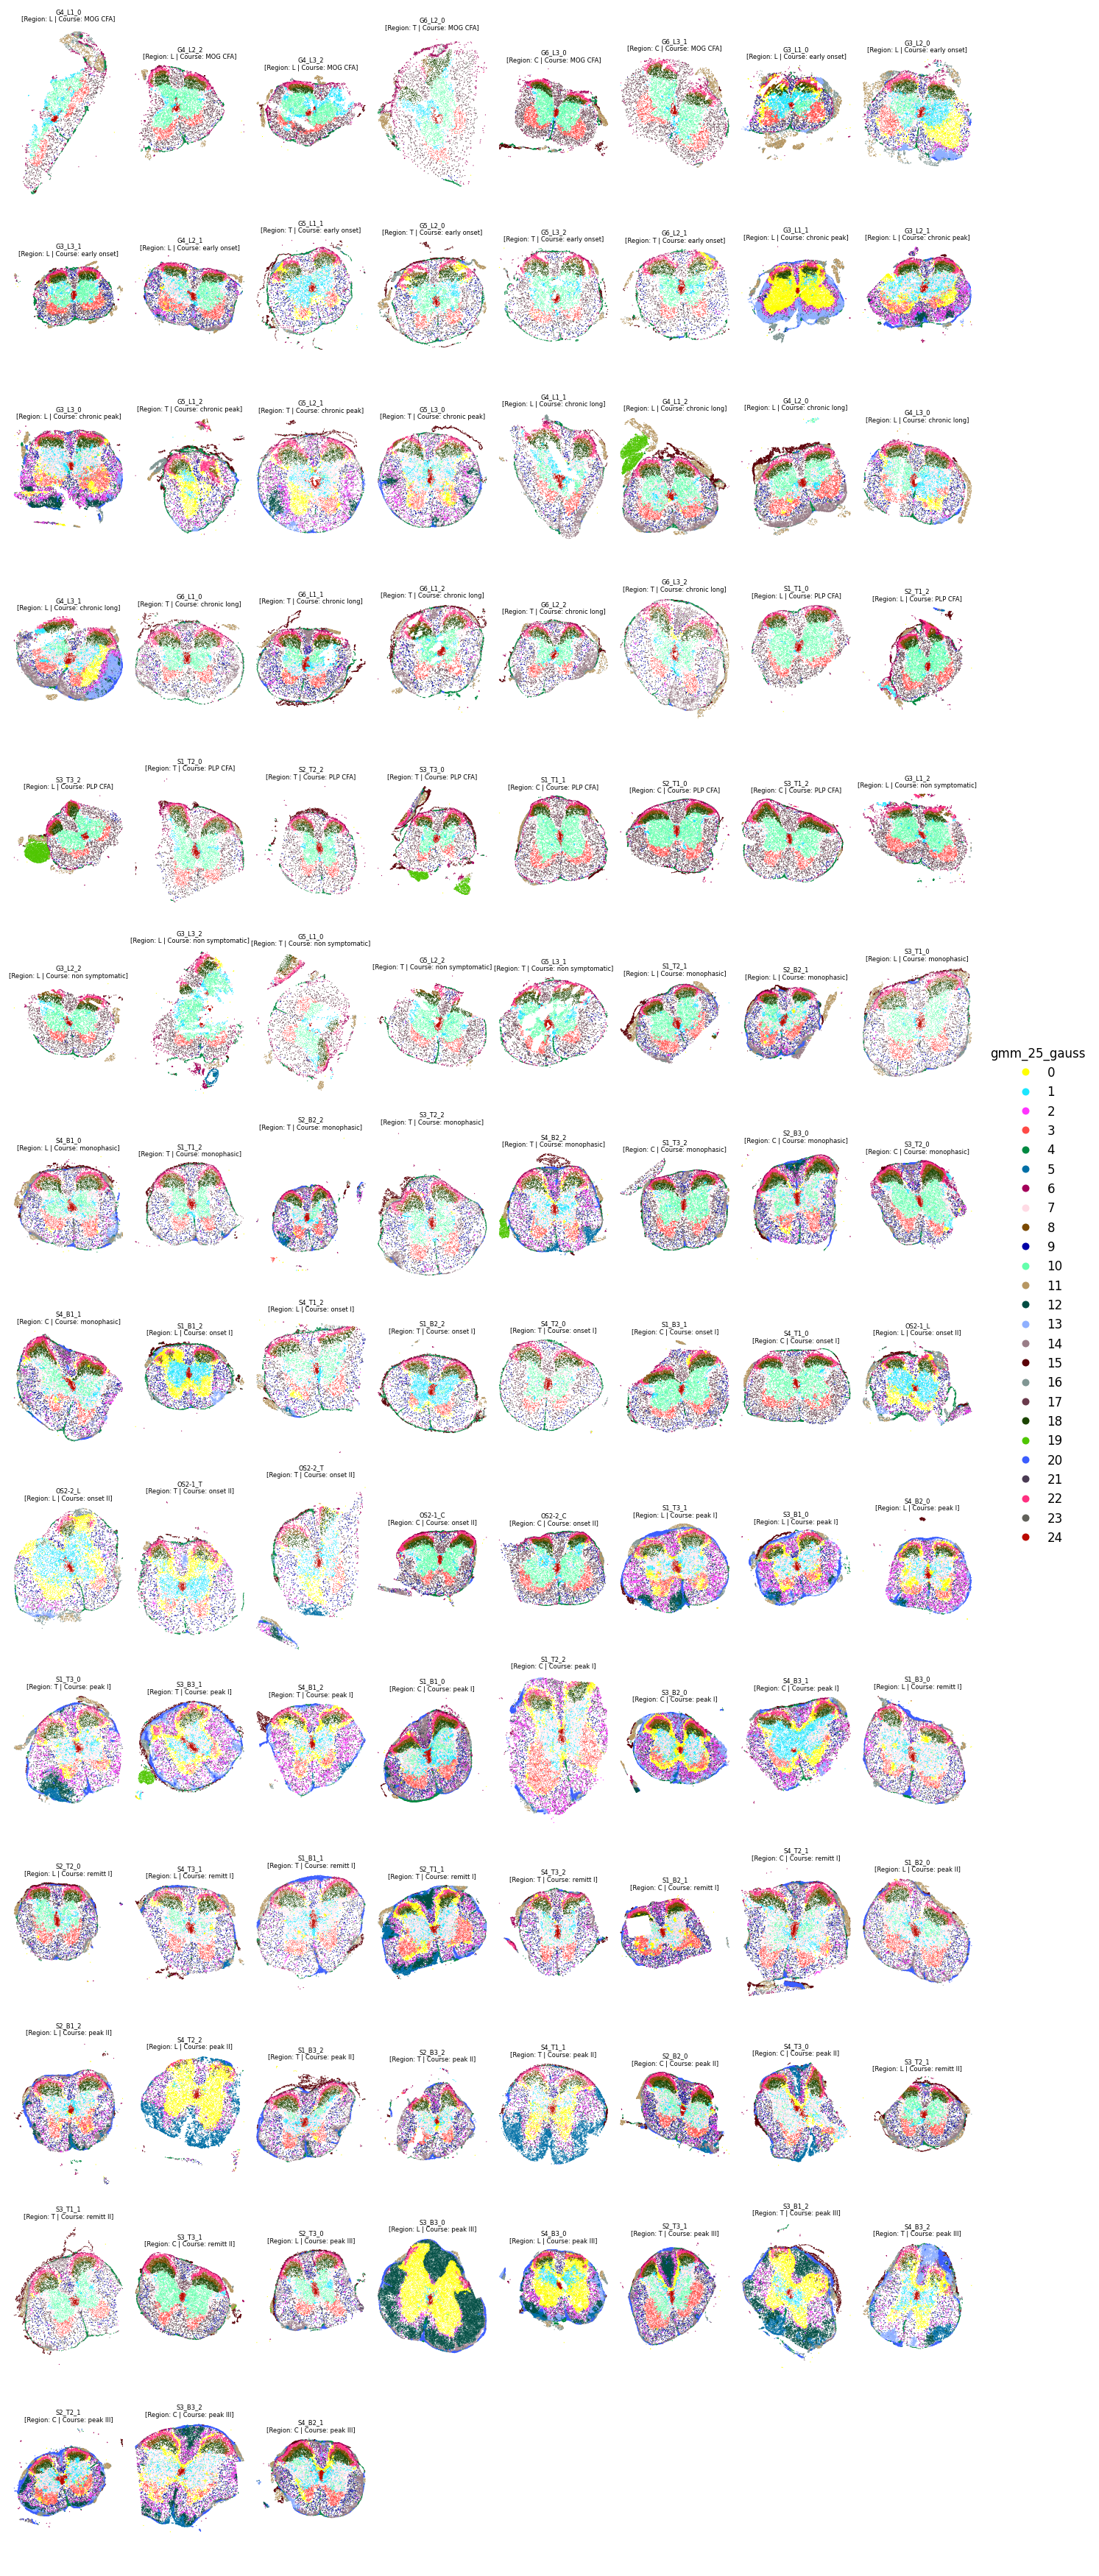

In [47]:
# Visualize MANA clustering (resolution 0.5 as starting point)
plot_spatial_compact_fast(
    adata,
    color='gmm_25_gauss',
    groupby='sample_id',  # Adjust to your actual sample column
    spot_size = 0.5,
    cols=8,
    height=30,
    background='white',
    dpi=120
)

## Part 6: Quality Control & Evaluation

Evaluate the clustering quality using metrics from MANA-6.

In [18]:
from sklearn.metrics import silhouette_score
import numpy as np

# Helper function from MANA-6
def local_purity(adata, cluster_key):
    """Compute spatial coherence: fraction of neighbors with same cluster label."""
    conn = adata.obsp['spatial_connectivities']
    labels = adata.obs[cluster_key].astype('category').cat.codes.values
    purities = []
    
    for i in range(adata.n_obs):
        neighbors = conn[i].nonzero()[1]
        if len(neighbors) > 0:
            neighbor_labels = labels[neighbors]
            purity = (neighbor_labels == labels[i]).mean()
            purities.append(purity)
    
    return np.mean(purities)

# Evaluate clustering
cluster_key = 'leiden_mana_0.5'

# Spatial coherence
purity = local_purity(adata, cluster_key)
print(f"Local purity (spatial coherence): {purity:.3f}")

# Expression coherence (in scVI space)
labels = adata.obs[cluster_key].astype('category').cat.codes.values
sil = silhouette_score(adata.obsm['X_scVI'], labels, metric='euclidean', sample_size=10000)
print(f"Silhouette score (expression coherence): {sil:.3f}")

# Cluster sizes
print(f"\nCluster sizes:")
print(adata.obs[cluster_key].value_counts().sort_index())

Local purity (spatial coherence): 0.716
Silhouette score (expression coherence): -0.033

Cluster sizes:
leiden_mana_0.5
0     157345
1     110671
2     104792
3      89892
4      79614
5      65530
6      46190
7      44940
8      43570
9      39907
10     19634
11     19154
12     19021
13     18997
14      6284
15      5871
16      3982
17       896
18       338
19       223
20       178
21        51
22        39
23        22
Name: count, dtype: int64


### Gene expression signatures of compartments

In [40]:
import pandas as pd

/Users/christoffer/miniconda3/envs/cellcharter-env-new/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/christoffer/miniconda3/envs/cellcharter-env-new/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/christoffer/miniconda3/envs/cellcharter-env-new/lib/python3.12/s

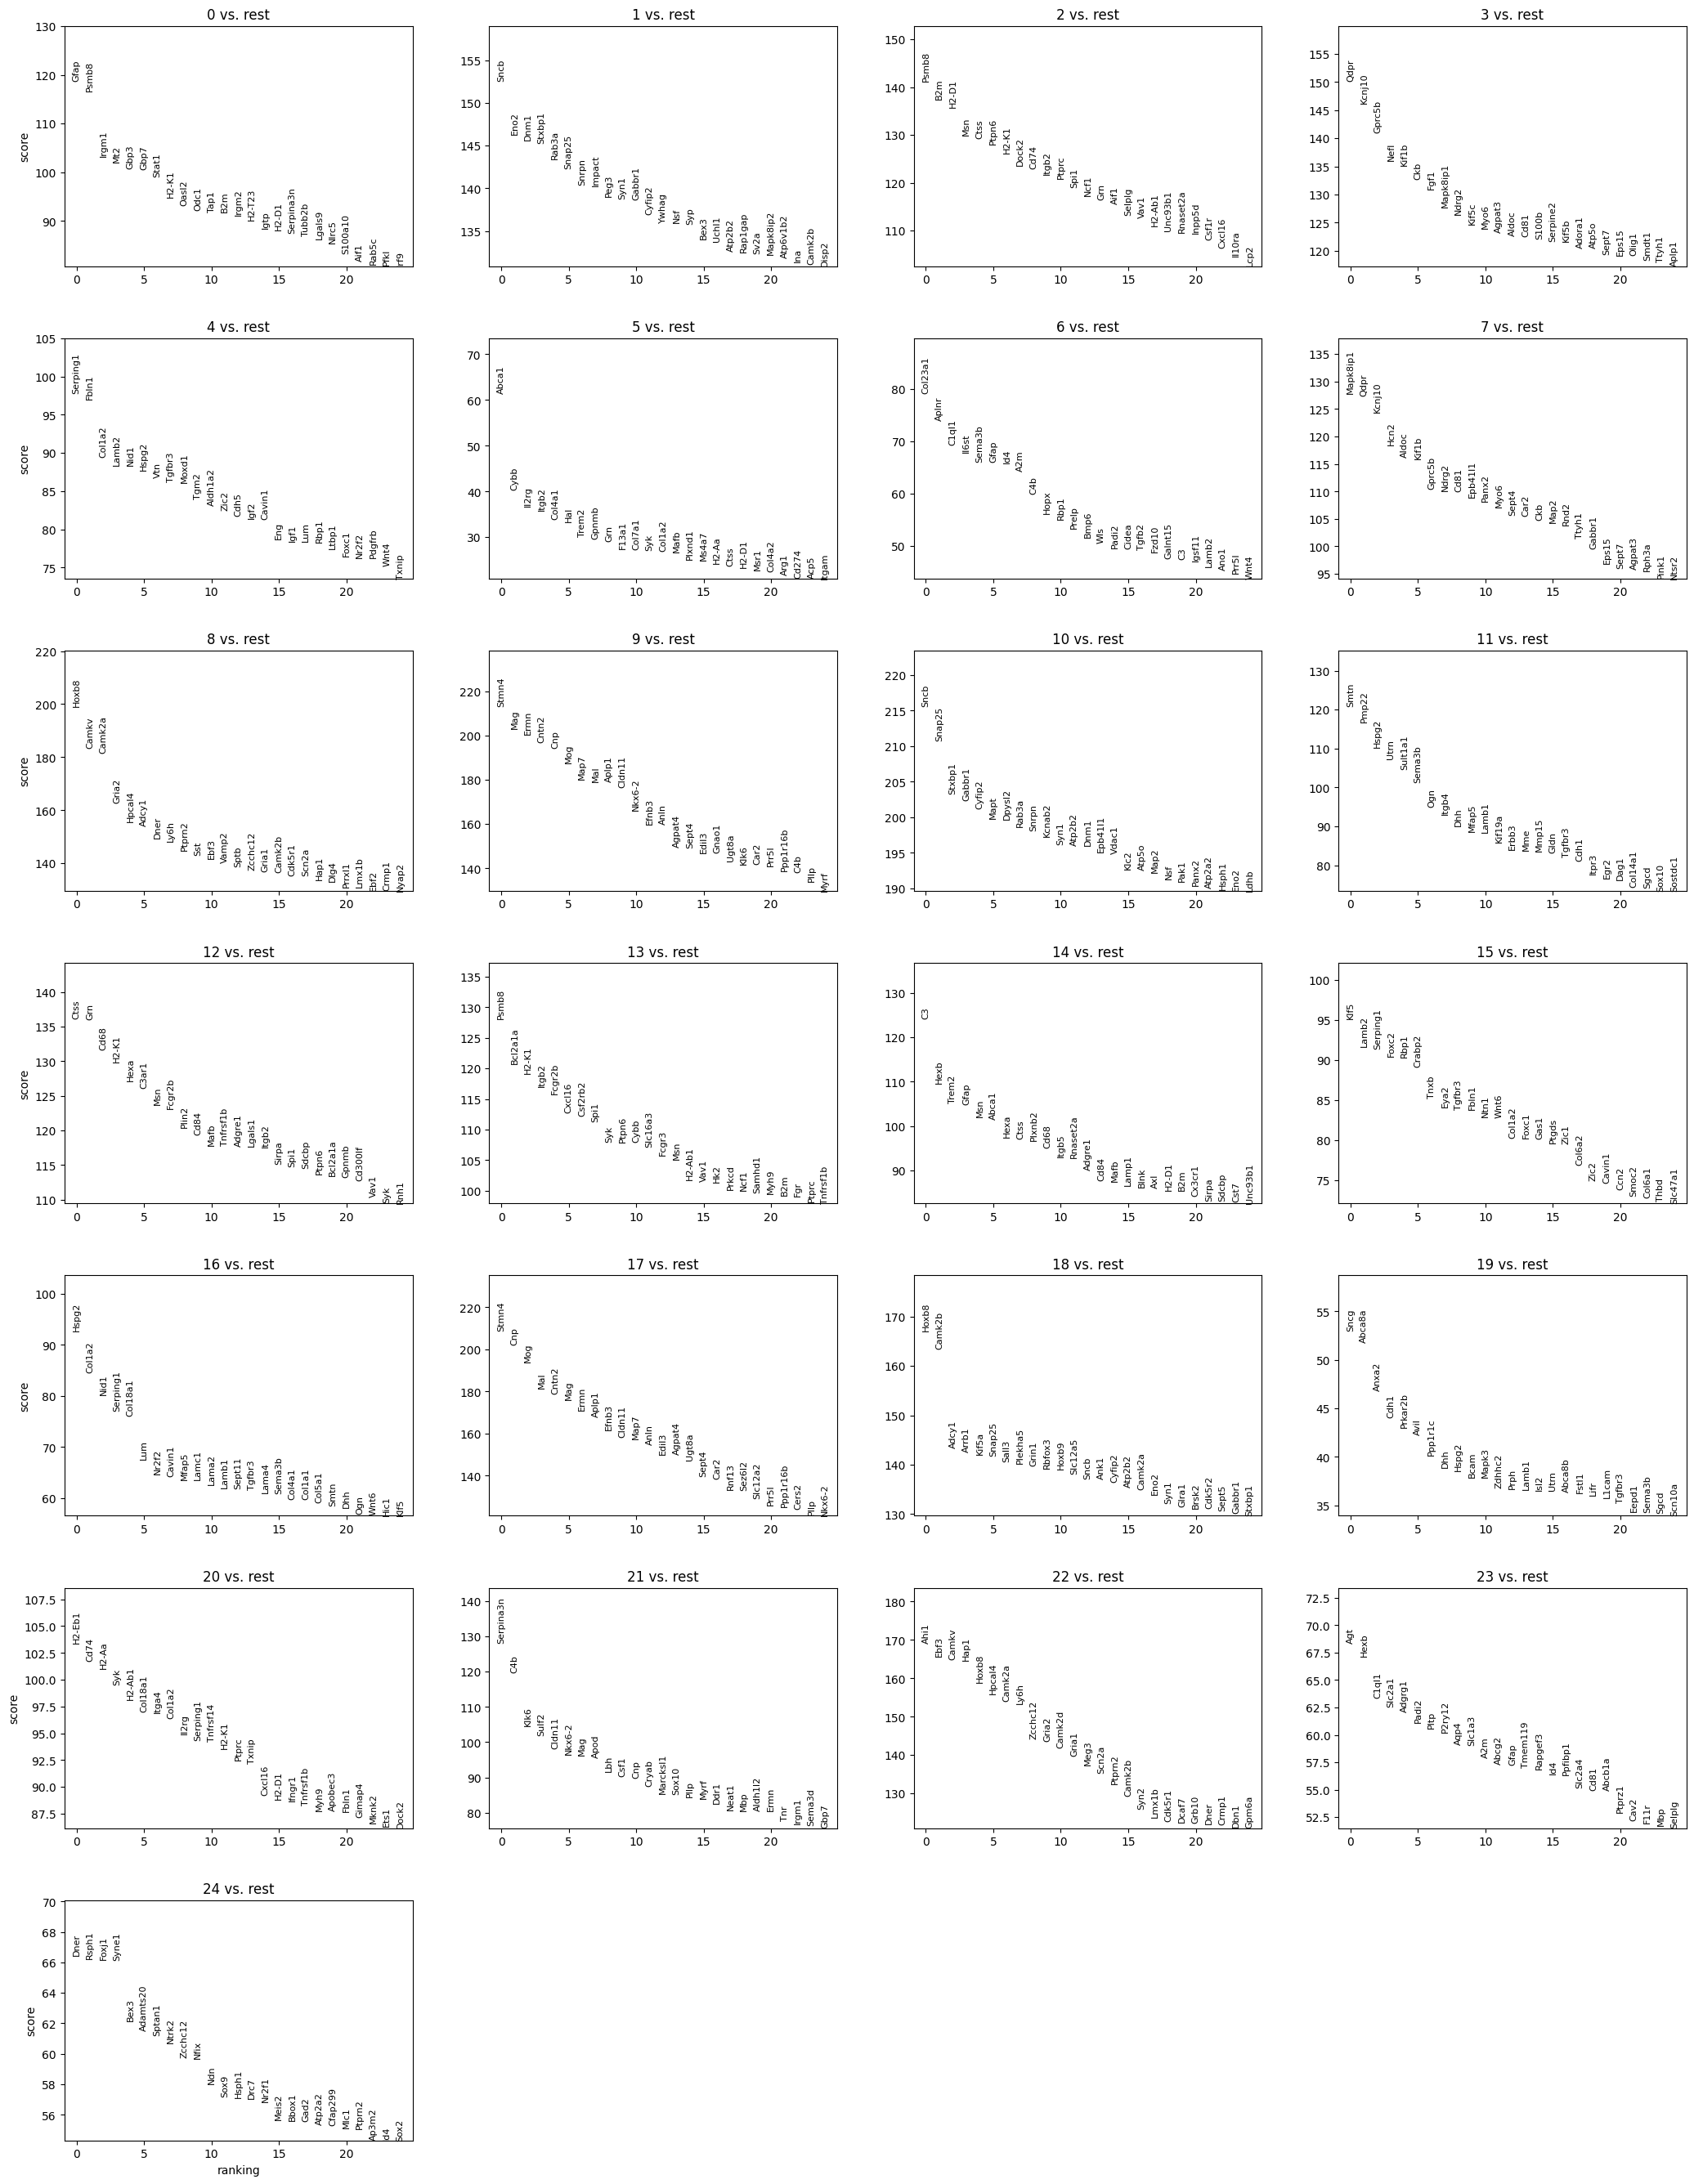

0
Gfap Psmb8 Irgm1 Mt2 Gbp3 Gbp7 Stat1 H2-K1 Oasl2 Odc1 Tap1 B2m Irgm2 H2-T23 Igtp H2-D1 Serpina3n Tubb2b Lgals9 Nlrc5 S100a10 Aif1 Rab5c Pfkl Irf9 Ndrg2 Stat2 Tssc4 Stat3 Isg15
 
1
Sncb Eno2 Dnm1 Stxbp1 Rab3a Snap25 Snrpn Impact Peg3 Syn1 Gabbr1 Cyfip2 Ywhag Nsf Syp Bex3 Uchl1 Atp2b2 Rap1gap Sv2a Mapk8ip2 Atp6v1b2 Ina Camk2b Disp2 Rtn3 Klc2 Cabp1 Tcaf1 Prkar1a
 
2
Psmb8 B2m H2-D1 Msn Ctss Ptpn6 H2-K1 Dock2 Cd74 Itgb2 Ptprc Spi1 Ncf1 Grn Aif1 Selplg Vav1 H2-Ab1 Unc93b1 Rnaset2a Inpp5d Csf1r Cxcl16 Il10ra Lcp2 Hexb H2-Aa Fcgr3 Itgam Cd300lf
 
3
Qdpr Kcnj10 Gprc5b Nefl Kif1b Ckb Fgf1 Mapk8ip1 Ndrg2 Kif5c Myo6 Agpat3 Aldoc Cd81 S100b Serpine2 Kif5b Adora1 Atp5o Sept7 Eps15 Olig1 Smdt1 Ttyh1 Aplp1 Fam107a Nefh Sept4 Trim2 Pink1
 
4
Serping1 Fbln1 Col1a2 Lamb2 Nid1 Hspg2 Vtn Tgfbr3 Moxd1 Tgm2 Aldh1a2 Zic2 Cdh5 Igf2 Cavin1 Eng Igf1 Lum Rbp1 Ltbp1 Foxc1 Nr2f2 Pdgfrb Wnt4 Txnip Lamc1 Il34 Vwf Bmp6 Itih5
 
5
Abca1 Cybb Il2rg Itgb2 Col4a1 Hal Trem2 Gpnmb Grn F13a1 Col7a1 Syk Col1a2 Mafb Plxnd1 M

In [48]:
key = "gmm_25_gauss"              # <-- change to your cluster column

sc.tl.rank_genes_groups(
    adata,
    groupby=key,
    reference="rest",             # each group vs all other cells
    method="t-test",
    pts=True,                     # add fraction expressing
)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

marker_genes = pd.DataFrame({
    group: adata.uns['rank_genes_groups']['names'][group][:30]
    for group in adata.uns['rank_genes_groups']['names'].dtype.names
})
for col in marker_genes.columns: 
    print(col)
    genes = marker_genes[col].tolist()
    print(" ".join(genes))
    print(' ')

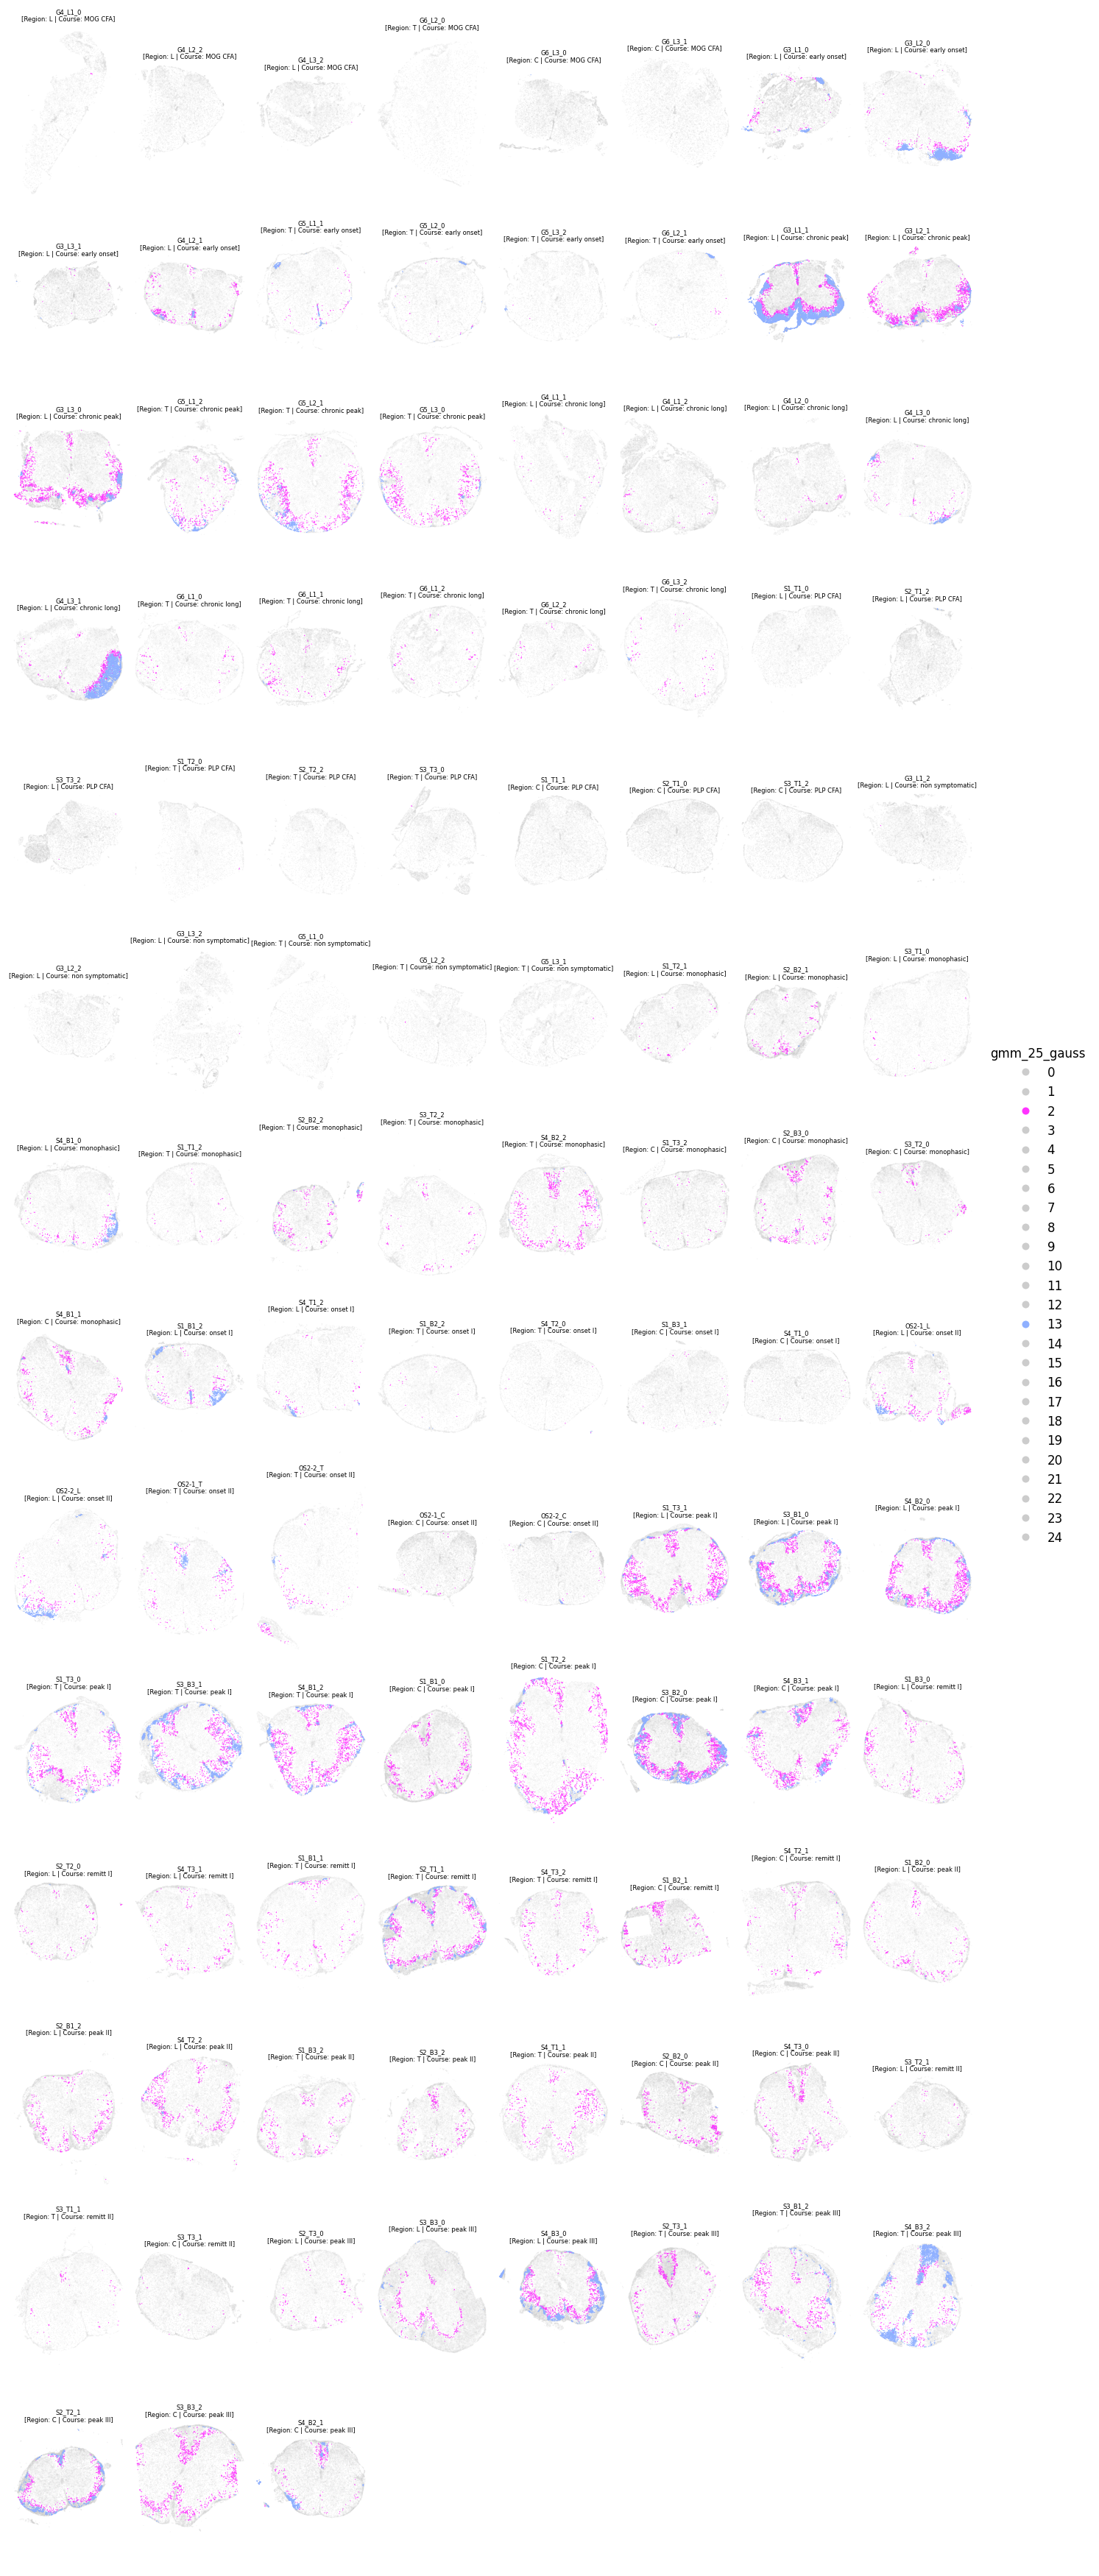

In [53]:
# Visualize MANA clustering (resolution 0.5 as starting point)
plot_spatial_compact_fast(
    adata,
    color='gmm_25_gauss',
    groupby='sample_id',  # Adjust to your actual sample column
    spot_size = 0.5,
    cols=8,
    height=30,
    background='white',
    dpi=120,
    highlight = ['2','13'],
)

## Part 7: Save Results

Save the annotated data with MANA clustering.

In [50]:
# Save annotated data
output_path = '/Volumes/processing2/RRmap/data/EAE_MANA_annotated_gmm_clust.h5ad'

# Optional: clean up .uns to avoid serialization issues
# Remove problematic entries if they exist
if 'cytetype_jobDetails' in adata.uns:
    del adata.uns['cytetype_jobDetails']

adata.write_h5ad(output_path)
print(f"Saved annotated data to: {output_path}")

Saved annotated data to: /Volumes/processing2/RRmap/data/EAE_MANA_annotated_gmm_clust.h5ad


## Optional: Compare with CellCharter

To validate MANA's superiority on this full dataset, run CellCharter for comparison.

In [ ]:
# Run CellCharter (uniform weights, no distance weighting)
aggregate_neighbors_weighted(
    adata,
    n_layers=3,
    aggregations='mean',
    use_rep='X_scVI',
    out_key='X_cellcharter',
    hop_decay=1.0,  # Uniform weights
    distance_kernel='none',  # No distance weighting
    spatial_key='spatial',
    normalize_weights=True,
    include_self=True,
)

# Cluster with CellCharter features
sc.pp.neighbors(adata, use_rep='X_cellcharter', n_neighbors=15, key_added='cellcharter')
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_cellcharter', neighbors_key='cellcharter')

print("CellCharter aggregation and clustering complete!")

In [ ]:
# Compare MANA vs CellCharter
print("=== MANA vs CellCharter Comparison ===\n")

# MANA metrics
mana_purity = local_purity(adata, 'leiden_mana_0.5')
mana_labels = adata.obs['leiden_mana_0.5'].astype('category').cat.codes.values
mana_sil = silhouette_score(adata.obsm['X_scVI'], mana_labels, metric='euclidean', sample_size=10000)

# CellCharter metrics
cc_purity = local_purity(adata, 'leiden_cellcharter')
cc_labels = adata.obs['leiden_cellcharter'].astype('category').cat.codes.values
cc_sil = silhouette_score(adata.obsm['X_scVI'], cc_labels, metric='euclidean', sample_size=10000)

print(f"Local Purity (Spatial Coherence):")
print(f"  MANA:        {mana_purity:.3f}")
print(f"  CellCharter: {cc_purity:.3f}")
print(f"  Improvement: {((mana_purity - cc_purity) / cc_purity * 100):+.1f}%\n")

print(f"Silhouette Score (Expression Coherence):")
print(f"  MANA:        {mana_sil:.3f}")
print(f"  CellCharter: {cc_sil:.3f}")
print(f"  Difference:  {(mana_sil - cc_sil):+.3f}")